## Fit a kernel to the full signal, measure accuracy

- Use GPyTorch
- Eclipsing binary + Pulsation + noise
- Matérn kernel

In [1]:
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
df = pd.read_csv("../data/sim_noisy_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

In [6]:
def plot_data(X, Y):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Plot observations
    plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])
    
def plot_lomb_scargle_periodogram(x, y, min_freq, max_freq, frequencies=None):
    if frequencies is not None:
        power = LombScargle(x, y).power(frequencies)
    else:
        frequencies, power = LombScargle(x, y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
    plt.figure(figsize=(35, 5))
    plt.plot(frequencies, power)
    plt.xlabel("frequency"), plt.ylabel("power")
    return frequencies, power

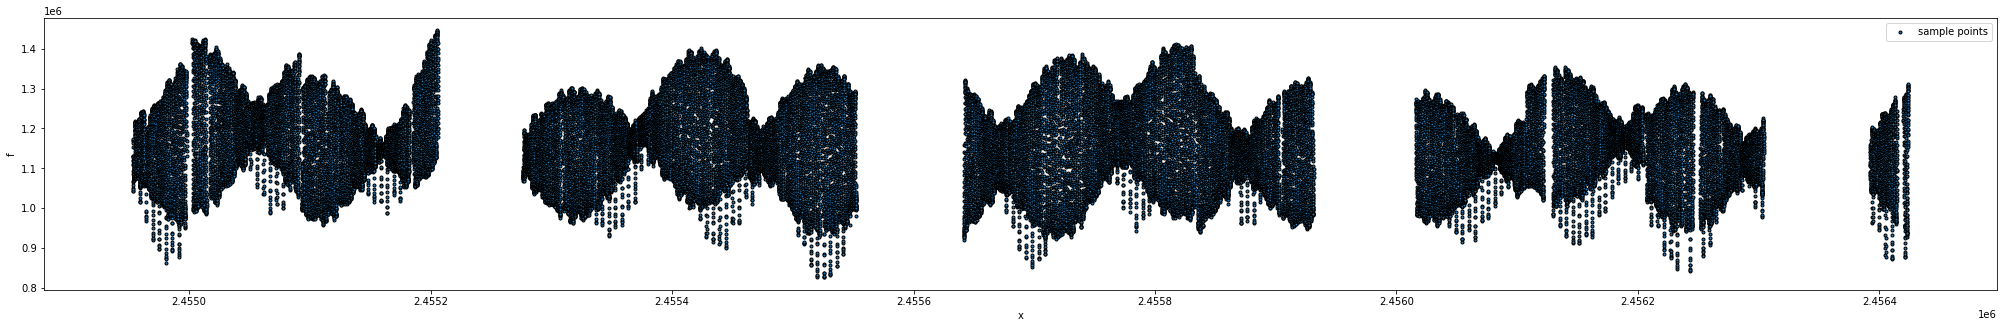

In [7]:
plot_data(X, Y)

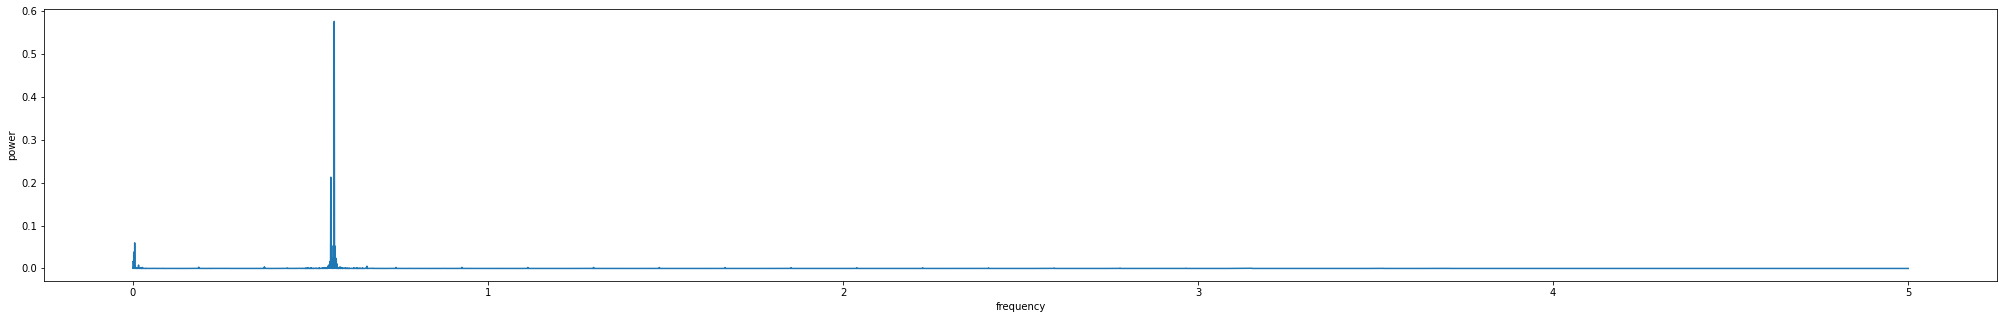

In [8]:
frequencies, power = plot_lomb_scargle_periodogram(X, Y, 0.0, 5)

In [9]:
N_part=4000

In [10]:
X_part=X[:N_part]
Y_part=Y[:N_part]

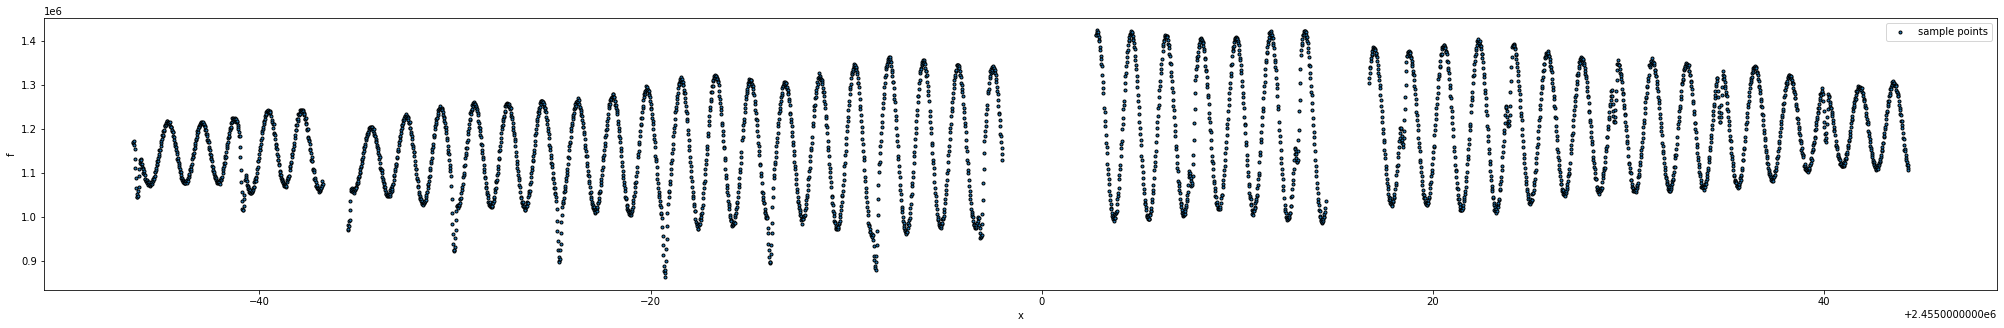

In [11]:
plot_data(X_part, Y_part)

# 2. Processing


Fit a simple smoothing kernel to the signal

In [12]:
def plot_kernel_samples(model, x, nr_of_samples=5):
    plt.figure(figsize=(35, 8))
    for i in range(nr_of_samples):
        Y_sample = model(x).sample()
        N = Y_sample.shape[0]
        plt.plot(range(N), Y_sample)

def plot_series(data_x, data_y, smooth_x=None, smooth_y=None, var=None):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    if not smooth_x is None:
        if not var is None:
            plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
        plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    
def plot_1d_kernel(kernel):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Predict evenly spaced points on our time-axis
    x = np.linspace(-6, 6, 1000)
    y = kernel.eval(x)
    
    # Plot observations
    plt.plot(x, y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])

def eval_2d(x):
    return np.array([x-i for i in x.tolist()])
    
def plot_2d_kernel(kernel):
    # Our sample space
    x = np.linspace(-5., 5., 250)
    grid = eval_2d(x)
    C = kernel.eval(grid)

    # Visualise covariance matrix on right hand side
    plt.pcolor(x.T, x, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

In [13]:
# normalize the data
mean, std = Y_part.mean(),Y_part.std()
Y_part = (Y_part - mean) / std

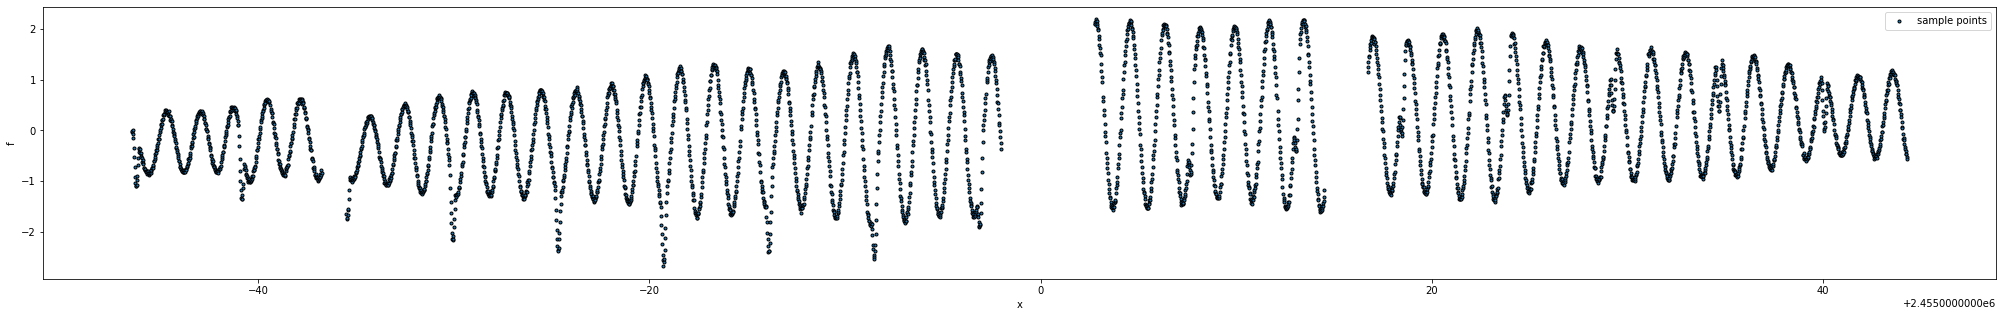

In [14]:
plot_data(X_part, Y_part)

In [15]:
X_part=torch.tensor(X_part)
Y_part=torch.tensor(Y_part)

Move data and models to the GPU

In [16]:
if USE_CUDA:
    X_part = X_part.cuda()
    Y_part = Y_part.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [17]:
from gpytorch.priors import NormalPrior

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # RBF kernel for the uncorrelated noise
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module.base_kernel.lengthscale=0.8

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_part, Y_part, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

In [18]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer on a subset of the hyperparameters
all_params = set(model.parameters())
optimizer = torch.optim.Adam(all_params, lr=0.15)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   Lengthscale: %.3f    noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale,
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.021   Lengthscale: 0.800    noise: 0.693
Iter 2/50 - Loss: 0.884   Lengthscale: 0.720    noise: 0.621
Iter 3/50 - Loss: 0.781   Lengthscale: 0.649    noise: 0.554
Iter 4/50 - Loss: 0.707   Lengthscale: 0.587    noise: 0.493
Iter 5/50 - Loss: 0.636   Lengthscale: 0.536    noise: 0.437
Iter 6/50 - Loss: 0.571   Lengthscale: 0.493    noise: 0.386
Iter 7/50 - Loss: 0.524   Lengthscale: 0.458    noise: 0.340
Iter 8/50 - Loss: 0.454   Lengthscale: 0.429    noise: 0.298
Iter 9/50 - Loss: 0.401   Lengthscale: 0.405    noise: 0.261
Iter 10/50 - Loss: 0.341   Lengthscale: 0.386    noise: 0.228
Iter 11/50 - Loss: 0.284   Lengthscale: 0.371    noise: 0.199
Iter 12/50 - Loss: 0.225   Lengthscale: 0.358    noise: 0.173
Iter 13/50 - Loss: 0.159   Lengthscale: 0.348    noise: 0.150
Iter 14/50 - Loss: 0.102   Lengthscale: 0.340    noise: 0.130
Iter 15/50 - Loss: 0.035   Lengthscale: 0.334    noise: 0.113
Iter 16/50 - Loss: -0.021   Lengthscale: 0.330    noise: 0.097
Iter 17/50 - Los

In [19]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [20]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_part_pred = likelihood(model(X_part))

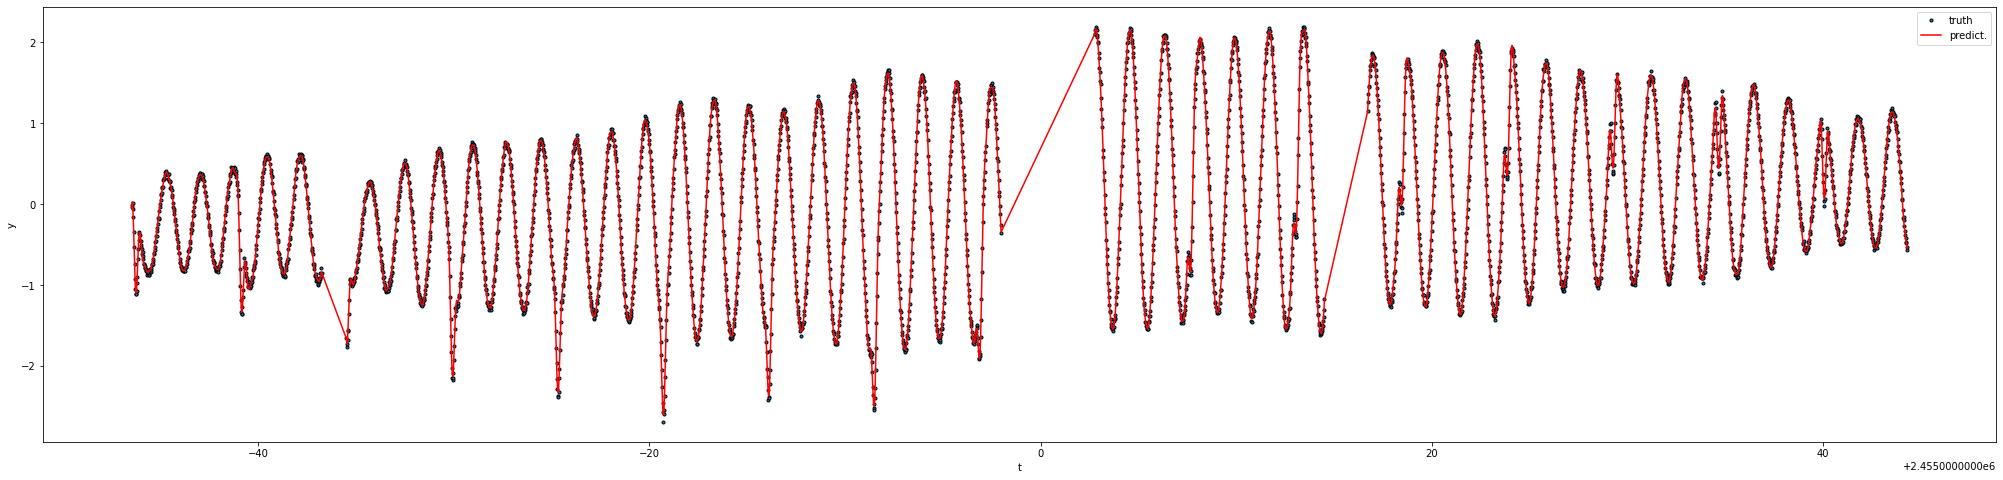

In [21]:
# Plot series with the original X positions
with torch.no_grad():
    plot_series(X_part.cpu().numpy(), Y_part.cpu().numpy(), X_part.cpu().numpy(), Y_part_pred.mean.cpu().numpy())

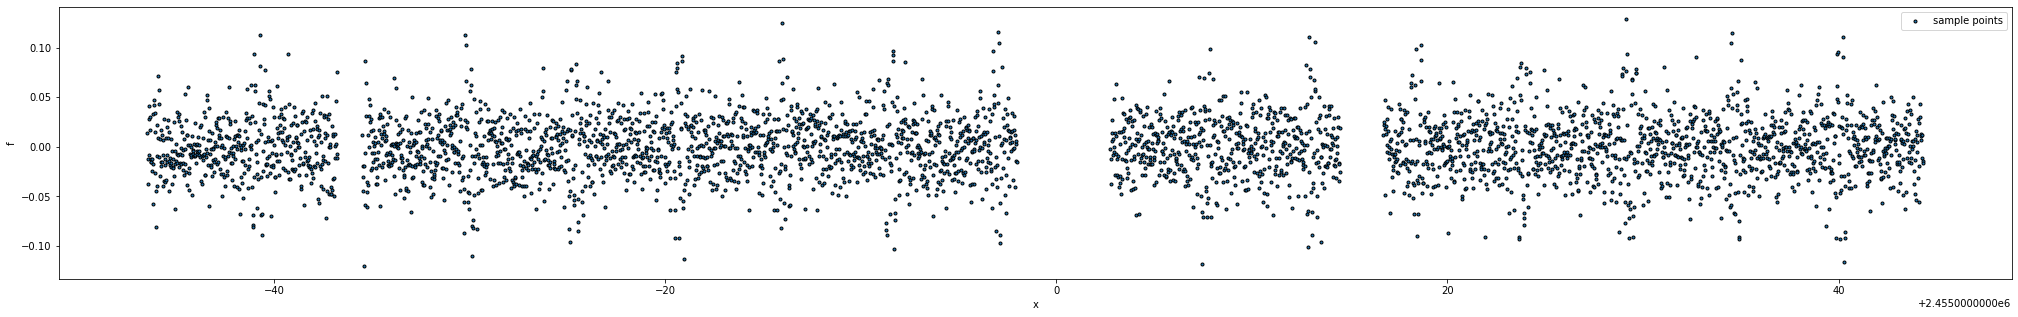

In [22]:
# Calculate the residuals on the original X positions!
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    residuals = Y_part.cpu()-Y_part_pred.mean.cpu().numpy()
    plot_data(X_part.cpu(), residuals)

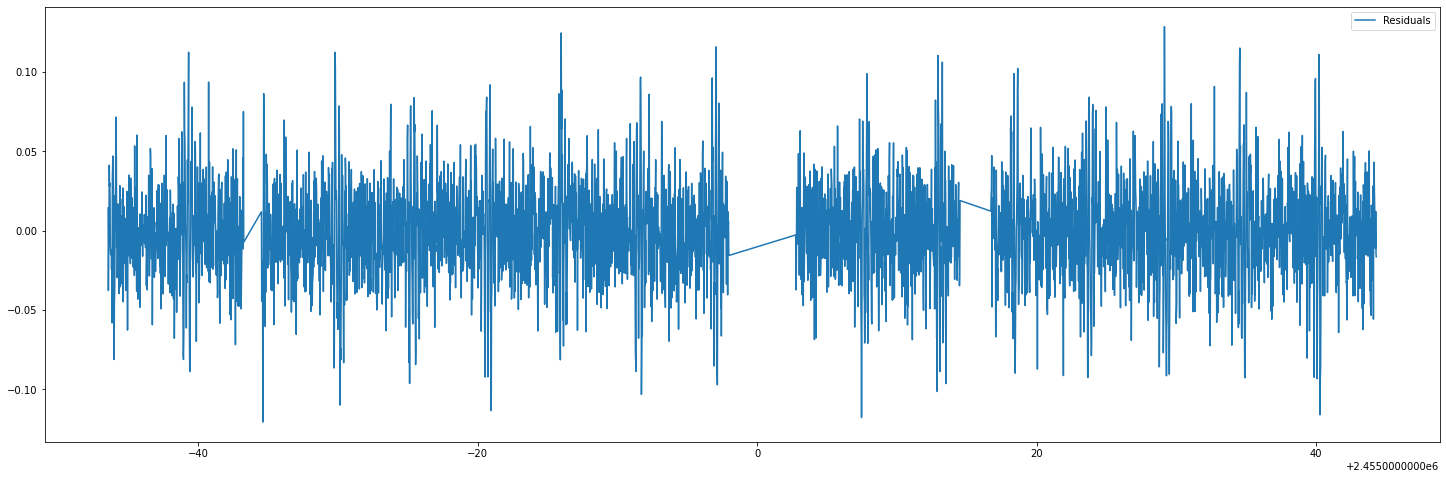

In [23]:
# Plot GP residuals
plt.figure(figsize=(25, 8))
plt.plot(X_part.cpu(), residuals, "-")
plt.legend(labels=["Residuals"])

### RMSE

In [24]:
np.sqrt(np.nanmean((Y_part_pred.mean.cpu().numpy()-Y_part.cpu().numpy())**2))

0.030573422785882532

In [25]:
print(model.covar_module.base_kernel.lengthscale.item())

0.19021435887688942


# Correlation between the original data and the fitted data

In [26]:
ts_orig = pd.DataFrame()
ts_orig['signal'] = Y_part.cpu().numpy()
ts_fitted = pd.DataFrame()
ts_fitted['signal'] = Y_part_pred.mean.cpu().numpy()

In [27]:
ts_orig.corrwith(ts_fitted)

signal   0.9995326701379142
dtype: float64

In [28]:
# 4000 data points
# Trial 1: 0.9993879075302063 correlation, 50 iterations, length scale: 0.20819413760826516
# Trial 2: 0.9996495773845258 correlation, 100 iterations, length scale: 0.18682588807289266

# 12000 data points
# Trial 1: 0.9996183045048753 correlation, 50 iterations, length scale: 0.11315121991279563
# Trial 2: 0.9996493196737065 correlation, 100 iterations, length scale: 0.09515259122517888

# Conclusion:
#    100 iterations results in a slightly higher correlation
#    TODO: Compare two timeseries visually, my guess is that on the one with 50 iterations does not reach the crests and throughs of the sine waves.